# Desafío - Naive Bayes
- Para realizar este desafío debes haber estudiado previamente todo el material disponibilizado correspondiente a la unidad.
- Una vez terminado el desafío, comprime la carpeta que contiene el desarrollo de los requerimientos solicitados y sube el .zip en el LMS.
- Desarrollo desafío:
    - El desafío se debe desarrollar de manera Individual.
    - Para la realización del desafío necesitarás apoyarte del archivo Apoyo Desafío - Naive Bayes.

## Descripción
- En esta sesión trabajaremos con una serie de base de datos sobre letras musicales de distintos artistas. Cada uno de los csv se encuentra en la carpeta dump dentro del proyecto.
- Cada csv tiene el nombre del artista a analizar. Los archivos contienen el nombre del artista, el género musical del artista, el nombre de la canción y las letras.
- En base a esta información, se les pide un modelo generativo que pueda predecir el género de una canción a partir de la letra de una canción.
- Existen 4 géneros que se registran en la base de datos.
- Se busca predecir el género en base a las frecuecias de palabras de cada canción, por lo que para esta actividad trabajaremos con un Multinomial Naive Bayes.

### Ejercicio 1: Preparar el ambiente de trabajo
- Importe los módulos `numpy`, `pandas`, `matplotlib`, `seaborn`, `glob` y `os` siguiendo las buenas prácticas. Los últimos dos módulos permitirán realizar la importación de múltiples archivos dentro de la carpeta `dump`.
- Para ello genere un objeto que guarde en una lista todos los archivos alojados en `dump` utilizando `glob.glob` y `os.getcwd()` para extraer las rutas absolutas.
- Posteriormente generé un objeto `pd.DataFrame` que contenga todos los `csv`.
- Asegúrese de eliminar la columna Unnamed: 0 que se genera por defecto.

In [1]:
# Utiliza esta celda para realizar los import solicitados
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import warnings

warnings.simplefilter('ignore')

In [2]:
# Utiliza esta celda para crear el DataFrame solicitado

archivos = glob.glob('dump/*.csv')

df_all = pd.DataFrame()
for arc in archivos:
    df = pd.read_csv(arc)
    df_all = df_all.append(df)

df_all = df_all.drop(columns = 'Unnamed: 0').reset_index(drop=True)
df_all.columns = ['artista', 'genero', 'cancion', 'letra']
df_all

,artista,genero,cancion,letra
0,Anthrax,metal,Deathrider,"Riding hard, high in the saddle \n Winged stee..."
1,Anthrax,metal,Metal Thrashing Mad,Racing down the road \n In a street machine of...
2,Anthrax,metal,I'm Eighteen,Lines form on my face and hands \n Lines form ...
3,Anthrax,metal,Panic,Move it to the front \n Reaching for the light...
4,Anthrax,metal,Subjugator,Out in the streets \n We're fighting tonight \...
...,...,...,...,...
9484,Weezer,rock,"Thief, You've Taken All That Was Me","Thief, of silent dreams \n Of golden scenes \n..."
9485,Weezer,rock,We Are All In Love,When your out with your friends \n In your new...
9486,Weezer,rock,We Go Together,We go together \n And that's to stay \n And in...
9487,Weezer,rock,What Is This I Find?,[Jonas]: \n What is this I find? \n [Wuan]: \n...


### Ejercicio 2: Descripción de los datos
- Utilizando el objeto creado en el Ejercicio 1, genere dos gráficos de barras que resuman la siguiente información:
    - La cantidad de canciones registradas por cada artista, ordenados de mayor a menor.
    - La cantidad de canciones registradas en cada género, ordenados de mayor a menor.
- Comente sobre las principales tendencias.

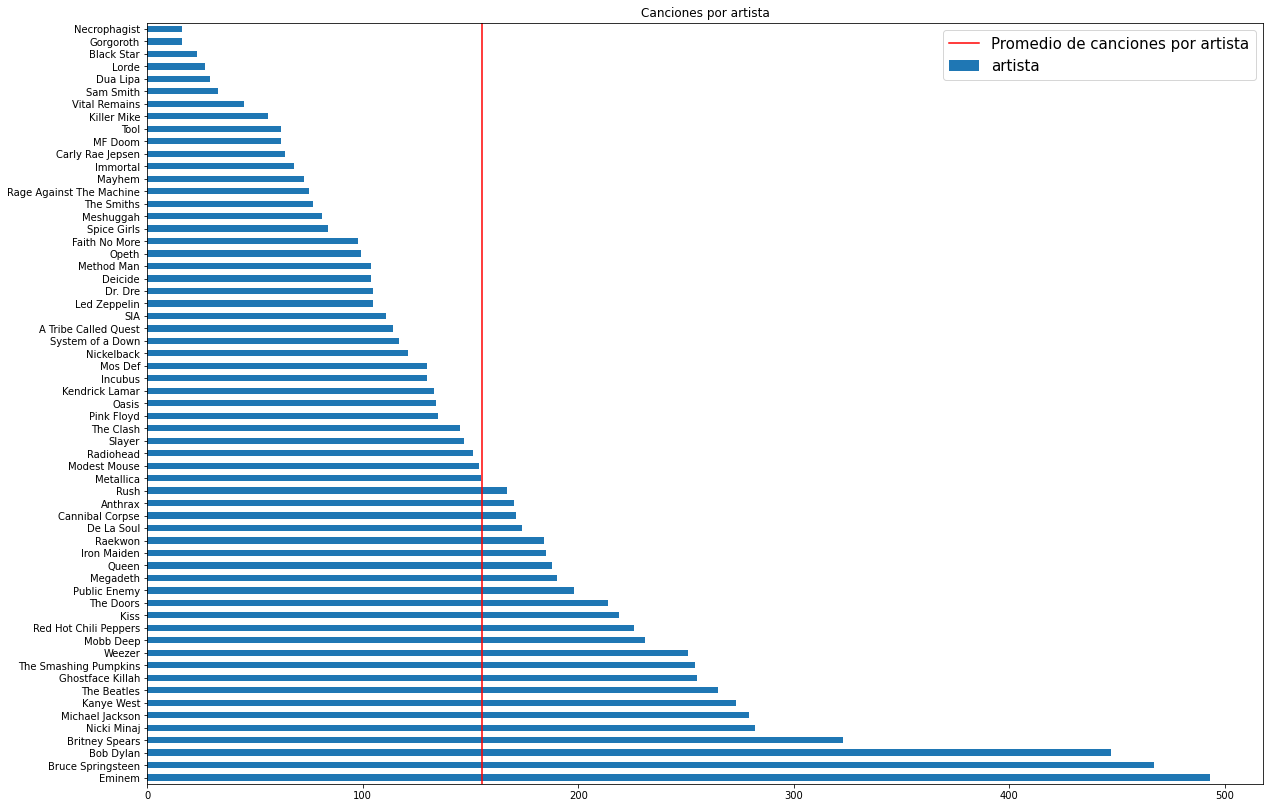

In [3]:
# Utiliza esta celda para el primer gráfico solicitado

plt.figure(figsize=(20,14))

df_all['artista'].value_counts().plot(kind='barh')

plt.title('Canciones por artista')
plt.axvline(df_all['artista'].value_counts().mean(), color='r', label = 'Promedio de canciones por artista');
plt.legend(prop={'size': 15});

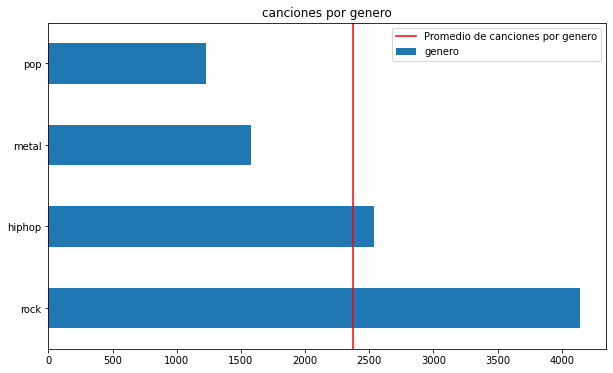

In [4]:
# Utiliza esta celda para el segundo gráfico solicitado

plt.figure(figsize=(10,6))

df_all['genero'].value_counts().plot(kind='barh')

plt.title('canciones por genero')
plt.axvline(df_all['genero'].value_counts().mean(), color='r', label = 'Promedio de canciones por genero')
plt.legend()

**Comentarios:**

- A partir del gráfico se observa que el rock es el género con más canciones, seguido por el hiphop. En cuanto a los artistas con más canciones, el top 3 son: Eminen, Bruce Springsteen y Bob Dylan con más de 400 canciones.

### Ejercicio 3: Matriz de ocurrencias

#### Digresión: Tokenización de Textos
Para poder trabajar con textos, debemos pasarlos a una matriz dispersa, donde cada fila representará una entrada (en este caso, una canción), y cada columna representará una palabra (token). Este es el proceso de tokenización: Identificar la ocurrencia de una palabra específica dentro de un conjunto de textos (corpus).

El tokenizador más simple `sklearn.feature_extraction.text.CountVectorizer` genera una colección de textos a una matriz que representa la frecuencia dentro del texto de una palabra específica.

- Importe la clase `CountVectorizer` dentro de los módulos `feature_extraction.text` de la librería `sklearn`. Lea la documentación asociada a ésta. ¿Cuál es el objetivo de esta clase?

**Respuesta**:

- Los datos en forma de texto requieren una preparación especial antes de comenzar a usarlos en el modelamiento predictivo.
- Se deben obtener las palabras que contiene el texto, este proceso se llama tokenización. Luego, las palabras deben ser codificadas como números para ser usados como entrada a los algoritmos de machine learning, esto es llamado extración de atributos o vectorización (feature extraction or vectorization).
- CountVectorizer utilice el modelo de bag of words, donde a cada palabra se le asigna un único número. Entonces, cualquier documento, puede ser codificado como un vector de largo fijo con el largo del vocabulario de palabras conocidas. El valor en cada posición del vector puede ser llenado con la cuenta o frecuencia de cada palabra codificada.
- CountVectorizer permite tokenizar y vectorizar una colección de documentos de texto y construir un diccionario de palabras conocidas, también puede codificar nuevos documentos usando ese diccionario. Para usar CountVectorizar se debe:
    - Crear una instancia de de la clase CountVectorizer.
    - Llamar a la función fit() para que la función aprenda el vocabulario de uno o más documentos.
    - Llamar a la función transform() sobre uno o más documentos para codificarlo como vector.

In [5]:
from sklearn.feature_extraction.text import CountVectorizer

- Aplique la clase para extraer las 100 palabras más repetidas en toda la base de datos

In [6]:
# instanciamos un objeto
count_vectorizer=CountVectorizer(stop_words='english', max_features=100)

# Implementamos los pasos fit y transform
count_vectorizer_fit = count_vectorizer.fit_transform(df_all["letra"])

# Extraemos tokens (palabras)
words = count_vectorizer.get_feature_names()

# extraemos frecuencia
words_freq = count_vectorizer_fit.toarray().sum(axis=0)

# Se crea un DataFrame para facilitar la visualización
words_freq_df = pd.DataFrame([words, words_freq]).T.sort_values(by=[1], ascending=False)
words_freq_df.columns = ["Palabra", "Frecuencia"]
words_freq_df.T

,51,18,44,31,43,57,98,54,67,11,...,38,10,78,42,21,15,47,82,20,79
Palabra,like,don,know,got,just,love,yeah,ll,oh,cause,...,high,boy,soul,inside,everybody,death,left,thing,end,stay
Frecuencia,19629,17398,14962,14171,13978,11268,11071,10028,9879,8356,...,1989,1971,1921,1915,1903,1897,1895,1882,1829,1828


- Genere una función que replique el procedimiento para cada uno de los géneros

In [7]:
# Utiliza esta celda para definir la función solicitada
def vectorizar_por_genero(df, genero, objetivo):
    df_tmp = df.copy()
    
    count_vectorizer = CountVectorizer(stop_words='english', max_features=100)
    count_vectorizer_fit = count_vectorizer.fit_transform(df_tmp[df_tmp['genero']==genero][objetivo])

    words = count_vectorizer.get_feature_names()
    words_freq = count_vectorizer_fit.toarray().sum(axis=0)

    df_words = pd.DataFrame(zip(words, words_freq), columns=['words','freq']).sort_values(by='freq', ascending=False)

    return df_words

- Comente sobre las principales características de cada género en cuanto a sus palabras.

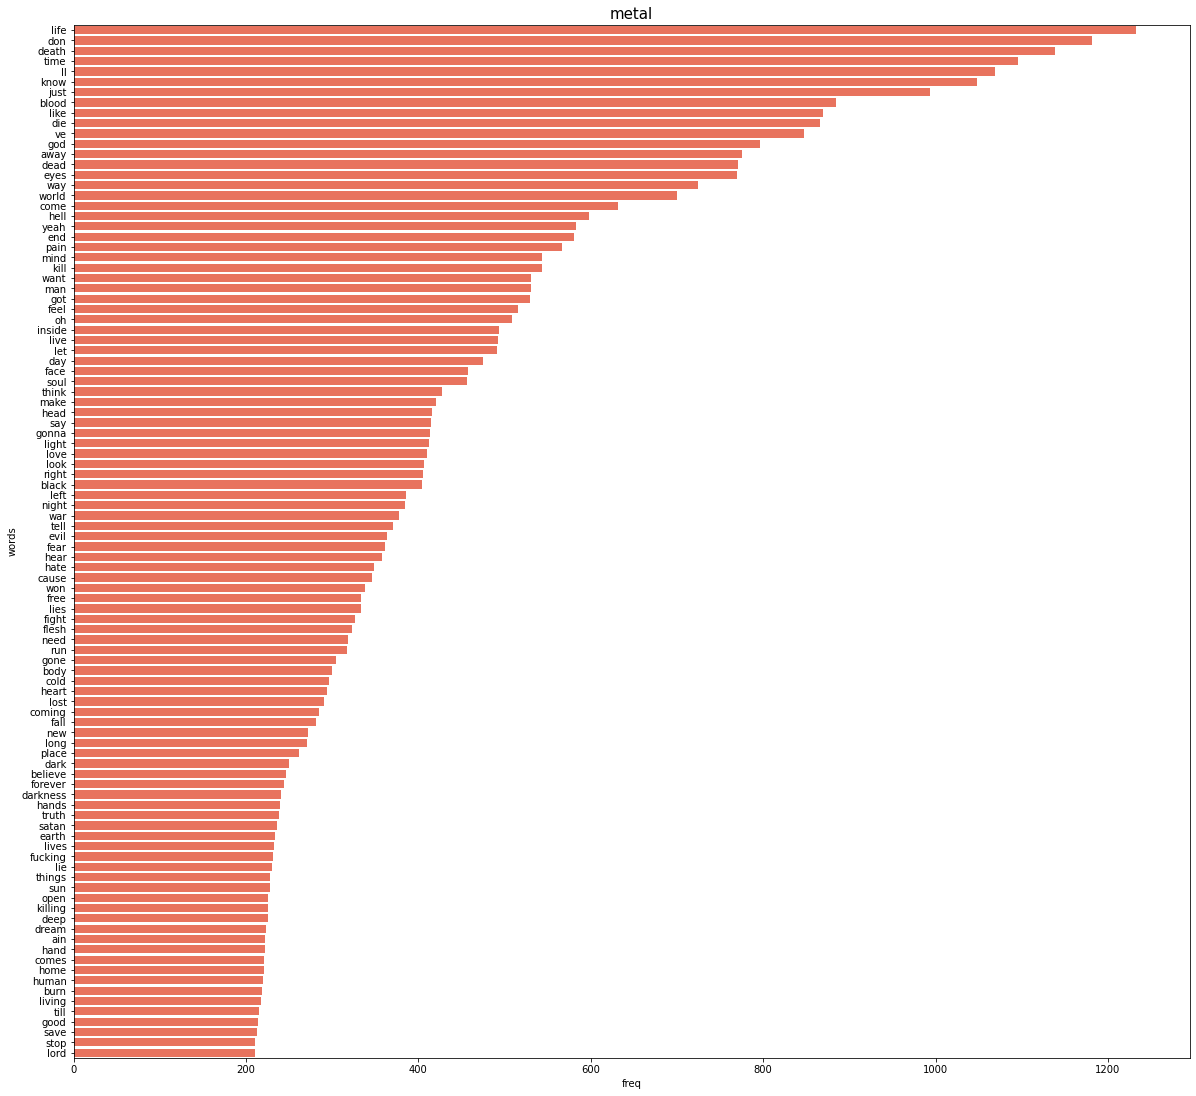

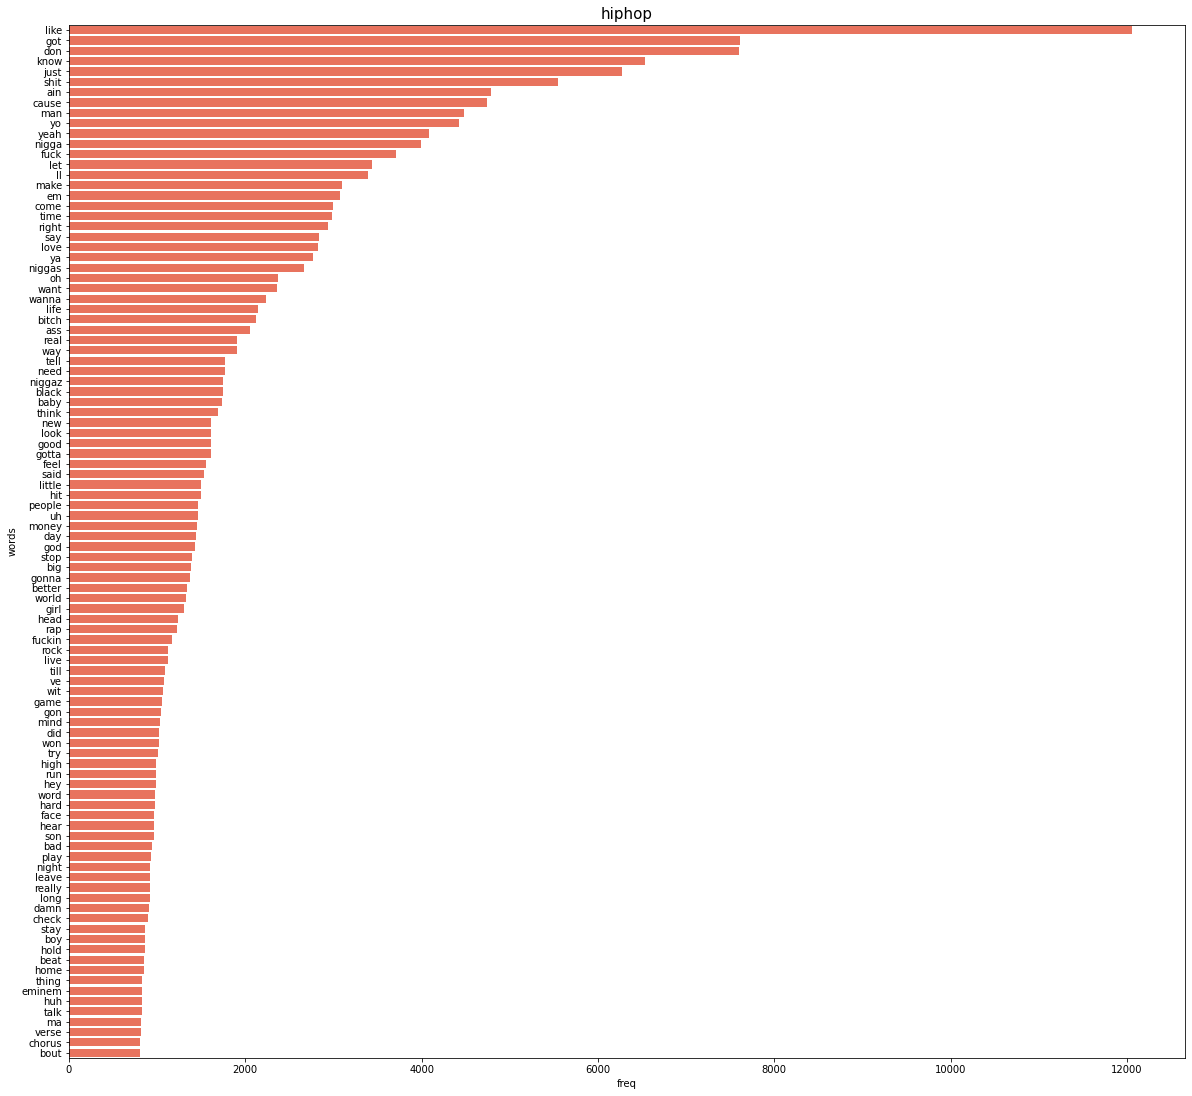

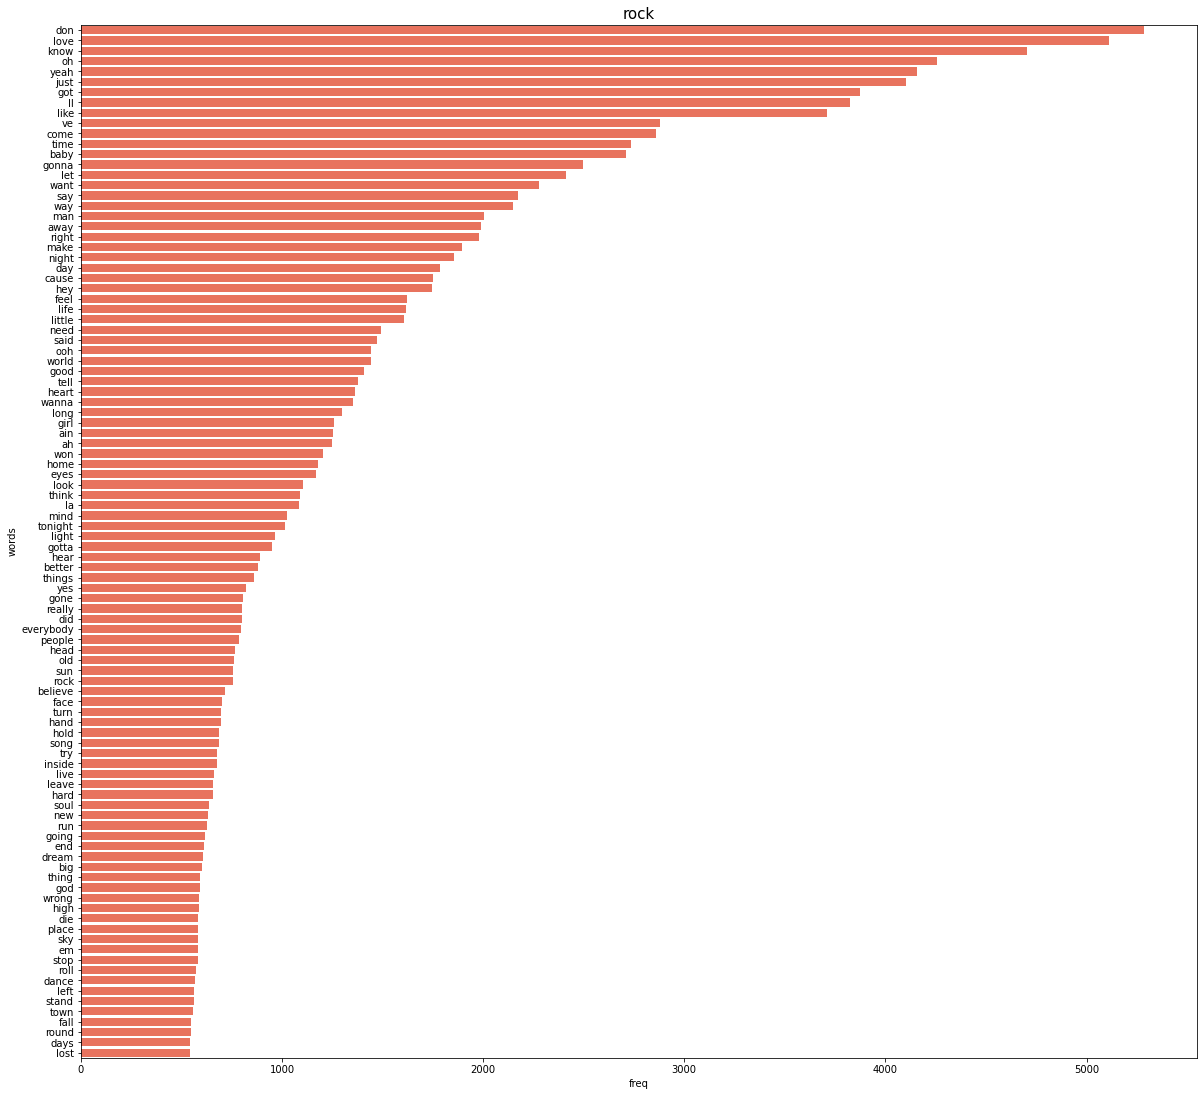

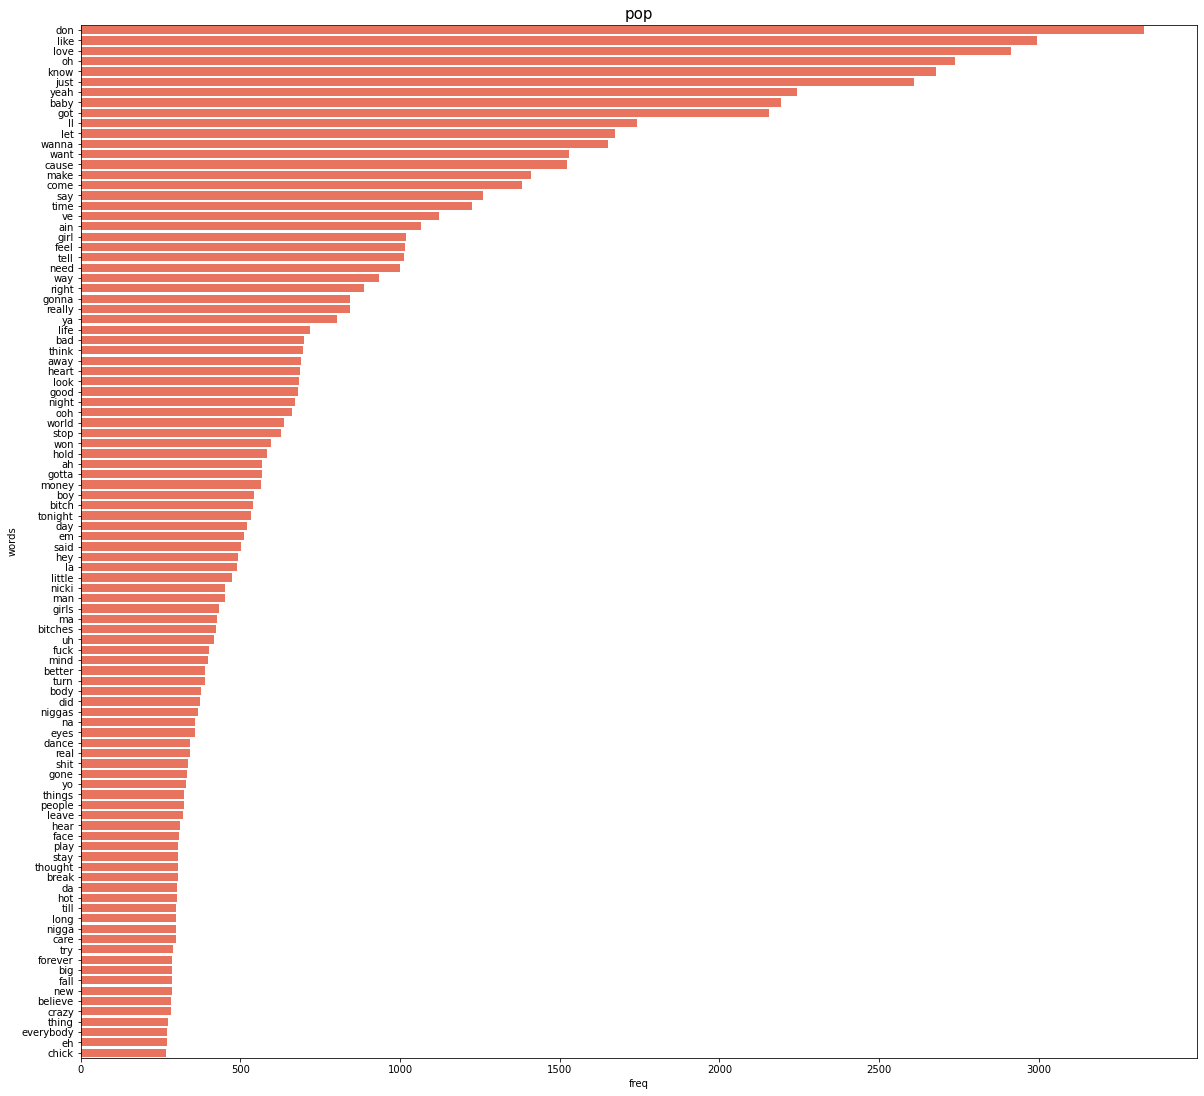

In [8]:
# Utiliza esta celda para hacer el llamado a la función para cada género. Tip: Usar unique() y un ciclo for. 
# Se puede mostrar las frecuencias usando plt.bar

for genero in df_all['genero'].unique():

    plt.figure(figsize=(20,19))

    df_genero = vectorizar_por_genero(df_all, genero, 'letra')
    sns.barplot(y=df_genero['words'], x=df_genero['freq'], color='Tomato')
    plt.title(genero, fontsize=15)

**Comentarios**

- Para `metal`, las palabras más frecuentes/usadas son `life`, `don` (esta palabra proviene de `"don't"`) y `death` 
- Para `hiphop`, las palabras más frecuentes/usadas son `like`, `got` y `don` (esta palabra proviene de `"don't"`)
- Para `rock`, las palabras más frecuentes/usadas son `don` (esta palabra proviene de `"don't"`), `like` y `know`
- Para `pop`, las palabras más frecuentes/usadas son `don` (esta palabra proviene de `"don't"`), `like` y `love`

### Ejercicio 4: Entrenamiento del Modelo

#### Digresión: sklearn Pipelines
La clase Pipeline del módulo `sklearn.pipeline` permite concatenar múltiples pasos de procesamiento y preprocesamiento en un estimador generado por algún método de scikit-learn. En sí, la clase cuenta con los métodos clásicos `fit`, `predict` y `score` y presenta un comportamiento idéntico a los demás objetos de scikit-learn. Uno de los usos más comunes es para concatenar pasos de preprocesamiento con un modelo. _Esto es especialmente útil cuando se quiere automatizar el uso de un modelo en producción_.

#### Componentes de un Pipeline
Imaginemos que deseamos implementar el siguiente modelo. Considerando un conjunto de datos, deseo Estandarizar, posteriormente extraer sus principales componentes y finalmente aplicar un modelo de regresión lineal. Este flujo se puede reexpresar como:
```python
pipeline_model = Pipeline([                      # Pipeline recibe una lista de tuplas, donde cada tupla tiene una etiqueta y un paso a realizar
    ('scale', StandardScaler()),                 # Paso 1: Estandarizar los datos
    ('pca', RandomizedPCA(n_components=3)),      # Paso 2: Aplicar PCA
    ('model', LinearRegression())                # Paso 3: Ajustar un modelo de regresión lineal
])
```

**Algunos de los elementos a considerar**:
- Cada paso se considera como una tupla, donde se declara el nombre del paso y la función a implementar. En este caso, nuestro primer paso es estandarizar la matriz, por lo que asociamos el método `StandardScaler` con el string `'scale'`.
- Todos los pasos declarados se incorporan en una lista, donde el orden de ingreso representa el orden de ejecución.

Posteriormente el objeto creado puede utilizarse con los siguientes métodos
- `pipeline_model.fit(X_train, y_train)`
- `y_hat = pipeline_model.predict(X_test)`

- Importe `MultinomialNB`, `train_test_split`, `Pipeline`, `ConfusionMatrixDisplay` y `classification_report`.

In [9]:
# Utiliza esta celda para importar los módulos solicitados

from sklearn.naive_bayes import  MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix

- Genere las muestras de entrenamiento y validación reservando un 40% para validación y declarando una semilla pseudoaleatoria.

In [10]:
# Utiliza esta celda para generar las muestras

X_train, X_test, y_train, y_test = train_test_split(df_all['letra'], df_all['genero'], test_size=0.3, random_state=13)

- Monte el modelo dentro de un `Pipeline`, donde el primer paso es implementar `CountVectorizer` y el segundo es ejecutar el clasificador `MultinomialNB` con `alpha=0.1`.

In [11]:
# Utiliza esta celda para crear el Pipeline solicitado y entrenarlo
mi_pipeline = Pipeline([('vectorizer', CountVectorizer(stop_words='english')),
                        ('model', MultinomialNB(alpha=0.1))])

ml = mi_pipeline.fit(X_train, y_train)

- A continuación se les presenta una lista de letras, ¿cuáles serían las predicciones correspondientes?

```python
[
    'I got a place in the underworld', # Brody Dalle - Underworld
    'As veils of ignorance, hatred retains Storm of arrows through karma Seeking light through samsara', # Gorguts - Forgotten Arrows
    "Bye bye Don't want to be a fool for you Just another player in your game for two You may hate me but it ain't no lie", # N'SYNC - Bye Bye Bye
    'Move bitch, get out the way Get out the way bitch, get out the way Move bitch, get out the way Get out the way bitch, get out the way', # Ludacris - Move Btch
    "Sexual violence doesn't start and end with rape It starts in our books and behind our school gate" # IDLES - Mother,
    "Take it from the girl you claimed to love You gonna get some bad karma I'm the one who had to learn to \
    build a heart made of armor From the girl who made you soup and tied your shoes when you were hurting\
    You are not deserving, you are not deserving" #Banks - Drowning
]
```

In [12]:
# Utiliza esta celda para realizar las predicciones para la lista de letras entregada

canciones_predecir = ['I got a place in the underworld', # Brody Dalle - Underworld
'As veils of ignorance, hatred retains Storm of arrows through karma Seeking light through samsara', # Gorguts - Forgotten Arrows
"Bye bye Don't want to be a fool for you Just another player in your game for two You may hate me but it ain't no lie", # N'SYNC - Bye Bye Bye
'Move bitch, get out the way Get out the way bitch, get out the way Move bitch, get out the way Get out the way bitch, get out the way', # Ludacris -Move B*tch
'Sexual violence doesn’t start and end with rape It starts in our books and behind our school gates' # IDLES - Mother,
"Take it from the girl you claimed to love You gonna get some bad karma I'm the one who had to learn to build a heart made of armor From the girl who made you soup and tied your shoes when you were hurting You are not deserving, you are not deserving" #Banks -Drowning
]

prediccion = ml.predict(canciones_predecir)

reales = ["rock", "metal", "pop", "hiphop", "pop"]

df_predict = pd.DataFrame(data={
    "letra": canciones_predecir,
    "genero predicho": prediccion,
    "genero real": reales
    }
)

df_predict

,letra,genero predicho,genero real
0,I got a place in the underworld,rock,rock
1,"As veils of ignorance, hatred retains Storm of...",metal,metal
2,Bye bye Don't want to be a fool for you Just a...,rock,pop
3,"Move bitch, get out the way Get out the way bi...",pop,hiphop
4,Sexual violence doesn’t start and end with rap...,rock,pop


- Genere una predicción implementando la muestra de validación y contraste las predicciones del modelo con las etiquetas verdaderas. Reporte las principales métricas.

In [13]:
# Utiliza esta celda para generar las predicciones en los datos de validación

y_hat = ml.predict(X_test)
y_hat

array(['hiphop', 'pop', 'hiphop', ..., 'rock', 'hiphop', 'hiphop'],
      dtype='<U6')

              precision    recall  f1-score   support

      hiphop       0.85      0.94      0.89       771
       metal       0.75      0.74      0.74       432
         pop       0.67      0.48      0.56       394
        rock       0.80      0.83      0.81      1250

    accuracy                           0.80      2847
   macro avg       0.77      0.75      0.75      2847
weighted avg       0.79      0.80      0.79      2847



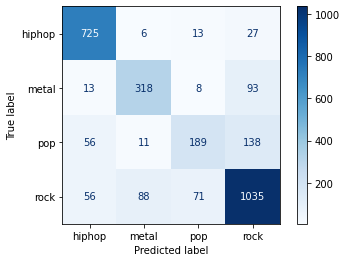

In [14]:
# Utiliza esta celda para reportar las métricas

print(classification_report(y_test, y_hat))

cm = confusion_matrix(y_test, y_hat, labels=ml.classes_)
cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=ml.classes_)
cm.plot(cmap='Blues');

**Comentarios**

- En terminos generales, el accuracy del modelo es del 80%, es decir, está logrando predecir correctamente el 80% del total de registros de testeo
- La precisión de cada género es:
    - hiphop: 85%.
    - metal: 75%
    - pop: 67%
    - rock: 80%
- La precisión más baja la tiene el género pop, lo que coincido con los resultados obtenidos de la muestra de 5 letras, donde no consiguio predecir correctamente el genero `pop`.
- En cuanto al recall, nuevamente, el género con más bajo recall es el pop, también para la métrica f1-score

### Ejercicio 5: Mejora del Modelo
- Proponga una estrategia para mejorar el desempeño del modelo en la categoría con peores métricas.
- Repita los pasos de entrenamiento y reporte de métricas, esta vez incluyendo los nuevos datos suministrados.
- Comente sobre el desempeño general de este.

**Para mejorar el desempeño del modelo, con bajo rendimiento en el pop, se requieren más datos. Se agregan, adicionalmente, los datos de la carpeta dump_plus_pop.**

In [15]:
# Utiliza esta celda para crear un nuevo df de lyrics en base a las letras en dump_plus_pop

def leer_csvs(patron = 'dump/*.csv'):
    archivos = glob.glob(patron)

    df_all = pd.DataFrame()
    for arc in archivos:
        df = pd.read_csv(arc)
        df_all = df_all.append(df)

    df_all = df_all.drop(columns = 'Unnamed: 0').reset_index(drop=True)
    df_all.columns = ['artista', 'genero', 'cancion', 'letra']

    return df_all

df_all_plus_pop = leer_csvs('dump_plus_pop/*.csv')
df_all_plus_pop

,artista,genero,cancion,letra
0,Anthrax,metal,Deathrider,"Riding hard, high in the saddle \n Winged stee..."
1,Anthrax,metal,Metal Thrashing Mad,Racing down the road \n In a street machine of...
2,Anthrax,metal,I'm Eighteen,Lines form on my face and hands \n Lines form ...
3,Anthrax,metal,Panic,Move it to the front \n Reaching for the light...
4,Anthrax,metal,Subjugator,Out in the streets \n We're fighting tonight \...
...,...,...,...,...
10799,Weezer,rock,"Thief, You've Taken All That Was Me","Thief, of silent dreams \n Of golden scenes \n..."
10800,Weezer,rock,We Are All In Love,When your out with your friends \n In your new...
10801,Weezer,rock,We Go Together,We go together \n And that's to stay \n And in...
10802,Weezer,rock,What Is This I Find?,[Jonas]: \n What is this I find? \n [Wuan]: \n...


In [16]:
# Utiliza esta celda para dividir las muestras y entrenar el pipeline

X_train_pop, X_test_pop, y_train_pop, y_tets_pop = train_test_split(df_all_plus_pop['letra'], df_all_plus_pop['genero'], test_size=0.3, random_state=13)

mi_modelo_plus_pop = mi_pipeline.fit(X_train_pop, y_train_pop)

              precision    recall  f1-score   support

      hiphop       0.81      0.92      0.86       764
       metal       0.80      0.75      0.77       485
         pop       0.68      0.64      0.66       772
        rock       0.76      0.75      0.75      1221

    accuracy                           0.76      3242
   macro avg       0.76      0.76      0.76      3242
weighted avg       0.76      0.76      0.76      3242



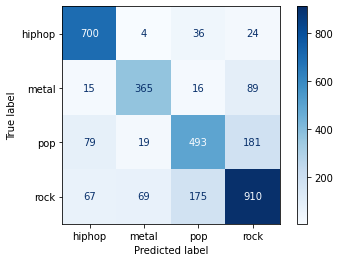

In [17]:
# Utiliza esta celda para mostrar las métricas de desempeño de nuevo modelo

y_hat_plus_pop = mi_modelo_plus_pop.predict(X_test_pop)

print(classification_report(y_tets_pop,y_hat_plus_pop ))

cm = confusion_matrix(y_tets_pop, y_hat_plus_pop, labels=mi_modelo_plus_pop.classes_)
cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mi_modelo_plus_pop.classes_)
cm.plot(cmap='Blues');

**Comentarios**

- En términos de accuracy, bajo levemente, pasando desde un 80% a un 76%, lo cual no es tan malo ya que el accuracy sigue siendo alto.
- Los nuevos resultados de la presición del modelo son:
    - hiphop: bajó desde 85% a 81%, lo cual, no es tan malo ya que sigue siendo alta la precisión.
    - metal: mejoró desde 75% a 80%%.
    - pop: mejoró levenetente, desde 67% a 68%
    - rock: bajó desde 80% a 76%, lo cual, no es tan malo ya que sigue siendo alta la precisión
- El cambio más grande fue en el recall del pop, que pasó desde un 48% a 64%, lo que significa que este nuevo modelo está reconociendo más canciones del género pop que el modelo anterior.
- En términos generales, este nuevo modelo es mucho mejor que el anterior.